# Kaggle Project - Medical Cost Prediction

## Download dataset from Kaggle website

Website Link: https://www.kaggle.com/mirichoi0218/insurance

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kthaladi","key":"a2ac326e90259cf6c824a3557940e60c"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d mirichoi0218/insurance

! unzip insurance.zip -d health-insurance

  0% 0.00/16.0k [00:00<?, ?B/s]
100% 16.0k/16.0k [00:00<00:00, 16.5MB/s]
Archive:  insurance.zip
  inflating: health-insurance/insurance.csv  


## Import Libraries

In [4]:
# Import Libraries:

# For reading data and data manipulations
import pandas as pd
import numpy as np
import pickle

# For plotting data visualisations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats  

# For data modeling
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, cross_val_predict
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Exploratory Data Analysis (EDA)

In [5]:
# Read in data file
health_ins_df = pd.read_csv("health-insurance/insurance.csv")
health_ins_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
health_ins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
print('There are',health_ins_df.shape[0], 'rows and', health_ins_df.shape[1], 'columns in this dataset.')

There are 1338 rows and 7 columns in this dataset.


In [8]:
# Are there any columns with missing values?
missing_fields = health_ins_df.columns[health_ins_df.isnull().any()]
missing_fields

Index([], dtype='object')

### Descriptive Statistics

In [9]:
health_ins_df.describe(include='all')
# Note: include = 'all' lets you view all variables regardless if they are numerical or categorical.
# Hence the 'Nan' for certain descriptve statistics metrics.

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


### **Key points from the summary:**

*   Total volume of patients = 1338
*   Age range: 18 to 64
*   BMI range: 15.96 to 53.13
*   Have children range: 0 to 5
*   Charges range: 1,121.87 to 63,770.43

In [10]:
health_ins_df.value_counts(['sex'], normalize=True)

sex   
male      0.505232
female    0.494768
dtype: float64

There is an equal number of male and females in this dataset.

In [11]:
health_ins_df.value_counts(['children'], normalize=True)

children
0           0.428999
1           0.242152
2           0.179372
3           0.117339
4           0.018685
5           0.013453
dtype: float64

Majority of the dataset contains patients with no children.

In [12]:
health_ins_df.value_counts(['region'], normalize=True)

region   
southeast    0.272048
southwest    0.242900
northwest    0.242900
northeast    0.242152
dtype: float64

Equally distributed dataset within the respective region.

In [13]:
health_ins_df.value_counts(['smoker'], normalize=True)

smoker
no        0.795217
yes       0.204783
dtype: float64

Majority of the dataset contains non-smoker patients.

### Data Visualisations

The above code concludes there are no missing data in the dataset.

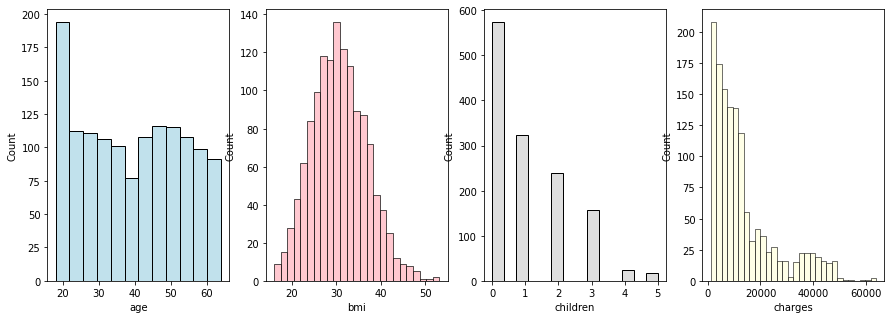

In [14]:
#Visualising columns with a histogram
fig,axes=plt.subplots(1,4,figsize=(15,5))
sns.histplot( health_ins_df['age'] , color="lightblue",ax=axes[0])
sns.histplot( health_ins_df['bmi'] , color="lightpink",ax=axes[1])
sns.histplot( health_ins_df['children'] , color="lightgrey",ax=axes[2])
sns.histplot( health_ins_df['charges'] , color="lightyellow",ax=axes[3])
plt.show()

Three different distributions seen in the above data.

* `Age` follows a **uniform** distribution.
* `BMI` follows a **normal** distribution.
* `Children` - it is not appropriate to conclude it is an **exponential** distribution.
* `Charges` follows an **exponential** distribution. *Note: we will ignore `Charges` field for now as we will be predicting the cost based on the independent variables (Age, Gender, BMI, Children, Smoker and Region).*

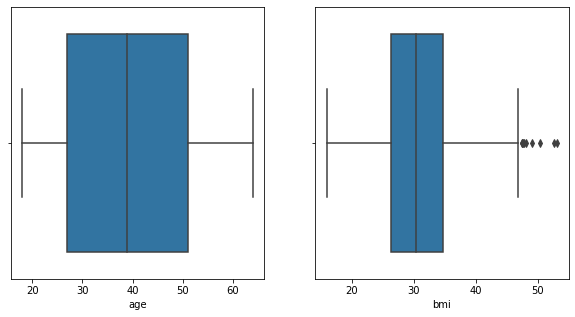

In [15]:
#Visualising numerical columns with a boxplot
fig,axes=plt.subplots(1,2,figsize=(10,5))

sns.boxplot(x = 'age', data = health_ins_df, ax=axes[0])
sns.boxplot(x = 'bmi', data = health_ins_df, ax=axes[1])

plt.show()

Looks like the `BMI` variable contains outliers. Let's run the following code to know more details about these outliers.

In [16]:
#Finding the outlier values in the bmi column
outlier_list = boxplot_stats(health_ins_df.bmi).pop(0)['fliers'].tolist()
print('The outlier values in BMI are: ', outlier_list)

#Finding the number of rows containing outliers
outlier_bmi_rows = health_ins_df[health_ins_df.bmi.isin(outlier_list)].shape[0]
print('Number of rows contaning outliers in BMI : ', outlier_bmi_rows)

#Percentage of rows which are outliers
percent_bmi_outlier = (outlier_bmi_rows/health_ins_df.shape[0])
print('Percentage of outliers in BMI columns : ', percent_bmi_outlier)

The outlier values in BMI are:  [49.06, 48.07, 47.52, 47.41, 50.38, 47.6, 52.58, 47.74, 53.13]
Number of rows contaning outliers in BMI :  9
Percentage of outliers in BMI columns :  0.006726457399103139


The outlier % is very small (0.0067 * 100 = 0.67%). Hence these rows can be dropped.

### Data Cleaning

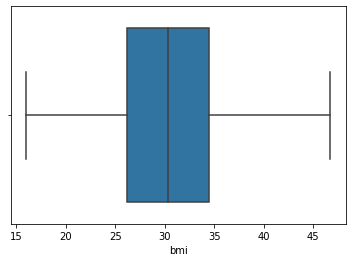

In [17]:
#Removing outier from bmi column
health_ins_df_clean = health_ins_df[~health_ins_df.bmi.isin(outlier_list)]
sns.boxplot(x = 'bmi', data = health_ins_df_clean)

From the above descriptive summary, we know that the patients' age ranges from 18 to 64. Let's create age categories/groups to the clean dataset.

In [18]:
#Creating Age categories

#Age between 18 to 40 years will fall under young
#Age between 41 to 58 years will fall under mid-age
#Age above 58 years will fall under old age

health_ins_df_clean.loc[(health_ins_df_clean['age'] >=18) & (health_ins_df_clean['age'] <= 40), 'age_group'] = 'young'
health_ins_df_clean.loc[(health_ins_df_clean['age'] >= 41) & (health_ins_df_clean['age'] <= 58), 'age_group'] = 'mid-age'
health_ins_df_clean.loc[health_ins_df_clean['age'] > 58, 'age_group'] = 'old'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [19]:
health_ins_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1329 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1329 non-null   int64  
 1   sex        1329 non-null   object 
 2   bmi        1329 non-null   float64
 3   children   1329 non-null   int64  
 4   smoker     1329 non-null   object 
 5   region     1329 non-null   object 
 6   charges    1329 non-null   float64
 7   age_group  1329 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 93.4+ KB


In [20]:
health_ins_df_clean.value_counts('age_group',normalize=True)

age_group
young      0.524454
mid-age    0.370956
old        0.104590
dtype: float64

### More Data Visualisations

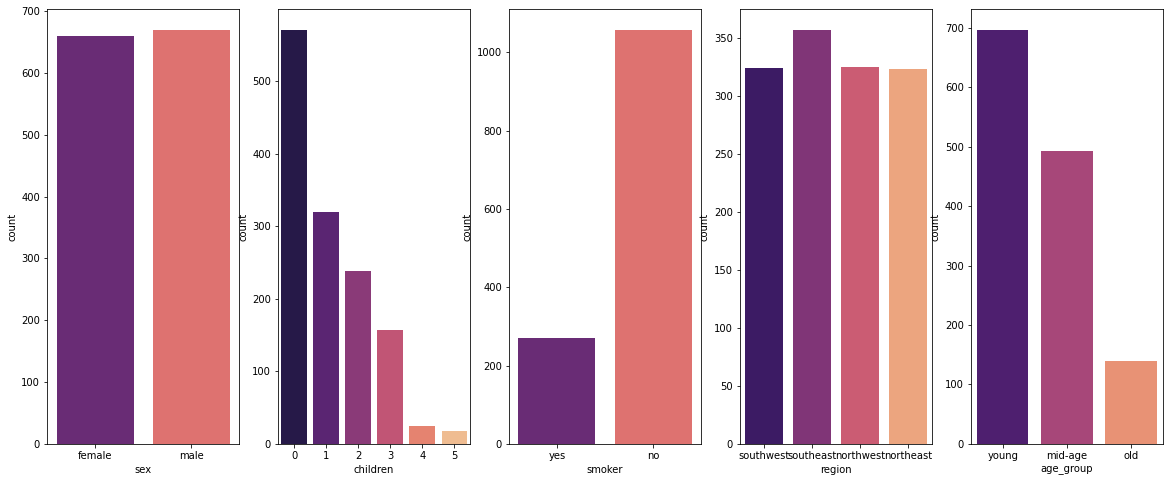

In [21]:
fig,axes=plt.subplots(1,5,figsize=(20,8))
sns.countplot(x = 'sex', data = health_ins_df_clean, palette = 'magma',ax=axes[0])
sns.countplot(x = 'children', data = health_ins_df_clean, palette = 'magma',ax=axes[1])
sns.countplot(x = 'smoker', data = health_ins_df_clean, palette = 'magma',ax=axes[2])
sns.countplot(x = 'region', data = health_ins_df_clean, palette = 'magma',ax=axes[3])
sns.countplot(x = 'age_group', data = health_ins_df_clean, palette = 'magma',ax=axes[4])

#### **Key points from the data visualisations:**

*  `Sex` and `Region` are equally distributed.
*  `Children`, `Smoker` and `Age Group` are not equally distributed.


### Univariate Analysis

#### Correlation - Heat Maps

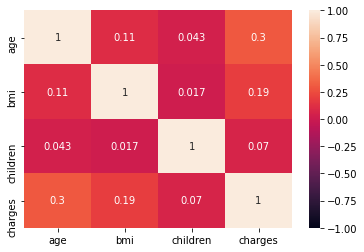

In [22]:
heatmap = sns.heatmap(health_ins_df_clean.corr(), vmin=-1, vmax=1, annot=True)

As per the correlation heat map, the `age` and `BMI` is most likely to cause an increase in the health care `charges` of a patient.

### Multivariate Analysis

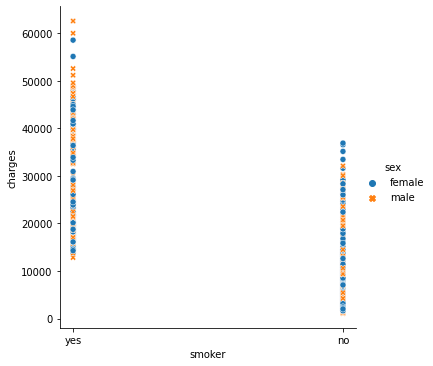

In [23]:
sns.relplot(x="smoker", y="charges",hue="sex", style = "sex", data=health_ins_df_clean);

This plot shows how the health insurance cost varies for smokers and non-smokers.
* Those who smoke have high charges for health insurance.
* Those who do not smoke have lower charges for health insurance.

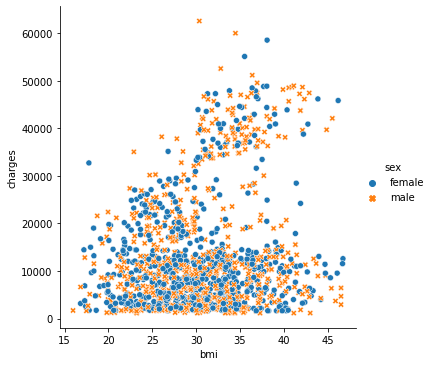

In [24]:
sns.relplot(x="bmi", y="charges",hue="sex", style = "sex", data=health_ins_df_clean);

The above plot shows how the health insurance charges can vary based on `BMI` and `Sex`.
* There are 2 clusters seen in the above plot:
Those who have a high `BMI` and charged more for health insurance.
* There is a much larger cluster of patients whose `BMI` ranges widely from low to high but their health insurance cost is relatively less. *Note: This could be one type of health insurance that customers can keep in mind when shopping for health insurance.*

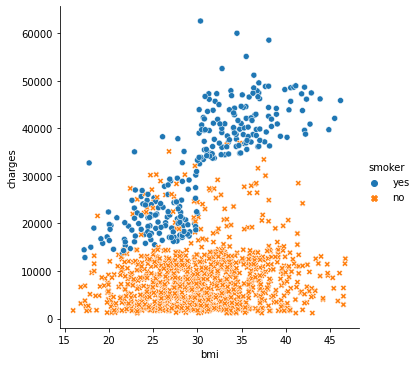

In [25]:
sns.relplot(x="bmi", y="charges",hue="smoker", style = "smoker", data=health_ins_df_clean);

The relationship is even more visible here!
* Those who **smoke**, their charges have linearly increased and so did their `BMI`!
* Those who **don't smoke**, their `BMI` varied from low to high but their health insurance charges stayed relatively low!

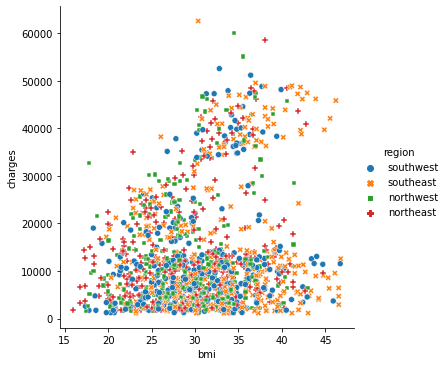

In [26]:
sns.relplot(x="bmi", y="charges",hue="region", style = "region", data=health_ins_df_clean);

There isn't a clear visual of the trend beased on the region.

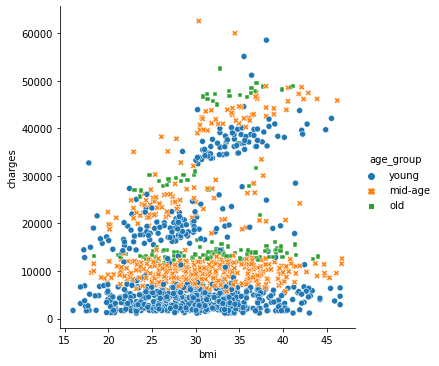

In [27]:
sns.relplot(x="bmi", y="charges",hue="age_group", style = "age_group", data=health_ins_df_clean);

There is a slight pattern seen here. Again, there are 2 types of clusters viewed in this dataset.
* The health insurance cost for **young** age patients is slightly less.
* The health insurance cost for **mid-age** patients has a relatively increase from the young age patients.
* The health insurance cost for **old** age patients is higher than young age and mid-age patients.

## Data Modeling

Now that we have a brief understanding of the data from the descriptive statistics and data visualisations, we can now create a data model and check our hypothesis of predicting medical cost/health insurance for patients based on their age, BMI, gender, no. of children, region, and smoker.

### Pre-processing

Prior to running a data model, we have to convert the data such that the model can predict well.

We will convert the categorical, nominal and ordinal variables using the **get_dummies** function in **pandas** library. Another alternative is to use the **One-Hot Encoding** in **scikit-learn** library.

In [28]:
 health_ins_df_clean.columns



Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'age_group'],
      dtype='object')

In [29]:
#Number of unique categories in catagorical variables
categorical_var = ['sex','children','smoker','region','age_group']
for cat_value in categorical_var:
  print(cat_value," - ",health_ins_df_clean[cat_value].unique())

sex  -  ['female' 'male']
children  -  [0 1 3 2 5 4]
smoker  -  ['yes' 'no']
region  -  ['southwest' 'southeast' 'northwest' 'northeast']
age_group  -  ['young' 'mid-age' 'old']


In [30]:
#Converting categorical values into dummies using one-hot encoding technique
health_ins_df_processed = pd.get_dummies(health_ins_df_clean, 
                                         columns=['sex','children','smoker','region','age_group'], 
                                         prefix=['sex','children','smoker','region','age_group'])
health_ins_df_processed.drop(['age'],axis = 1,inplace=True)

health_ins_df_processed.head()

,bmi,charges,sex_female,sex_male,children_0,children_1,children_2,children_3,children_4,children_5,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_group_mid-age,age_group_old,age_group_young
0,27.900,16884.92400,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1
1,33.770,1725.55230,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2,33.000,4449.46200,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,22.705,21984.47061,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
4,28.880,3866.85520,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1


In [31]:
health_ins_df_processed.shape

(1329, 19)

### **Model:** Base

In [32]:
#Building linear regression model
X = health_ins_df_processed.loc[:, health_ins_df_processed.columns != 'charges']
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     295.0
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:28:01   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1315   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4565.8126    360.93

### Key points from the base model:
* Adjusted R-square is 74.2% means our model is able to explain 74.2% variation in the data
* Variables - children_1, children_3, children_5, region_southeast, region_southwest have a p-value > alpha which means that these variables are insignificant in predicting our target variable - `Charges`.
* We can drop these insignificant variables in next iteration.

### Variance Inflation Factor (VIF)

VIF let's you check the insignificant variables which will help us to eliminate those variables from the OLS (Ordinary Least Squares) model.

In [33]:
health_ins_df_processed.columns

Index(['bmi', 'charges', 'sex_female', 'sex_male', 'children_0', 'children_1',
       'children_2', 'children_3', 'children_4', 'children_5', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest', 'age_group_mid-age',
       'age_group_old', 'age_group_young'],
      dtype='object')

In [34]:
# Variance Inflation Factor
health_ins_df_vif = health_ins_df_processed[['bmi', 'sex_female', 'sex_male', 'children_0', 
                                             'children_1','children_2', 'children_3', 'children_4', 
                                             'children_5', 'smoker_no','smoker_yes', 'region_northeast', 
                                             'region_northwest','region_southeast', 'region_southwest', 
                                             'age_group_mid-age','age_group_old', 'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.099784
1          sex_female       inf
2            sex_male       inf
3          children_0       inf
4          children_1       inf
5          children_2       inf
6          children_3       inf
7          children_4       inf
8          children_5       inf
9           smoker_no       inf
10         smoker_yes       inf
11   region_northeast       inf
12   region_northwest       inf
13   region_southeast       inf
14   region_southwest       inf
15  age_group_mid-age       inf
16      age_group_old       inf
17    age_group_young       inf


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


**Note: The "inf" states that the VIF values for the variables are too large (i.e. infinity). We will need to drop variables (i.e. those that have an insignificant p-value) one by one and check if the VIF values have reduced.**

#### Variable: Children_1

In [35]:
#Dropping children_1
X = health_ins_df_processed[['bmi','sex_female', 'sex_male', 'children_0','children_2', 'children_3', 
                             'children_4', 'children_5', 'smoker_no','smoker_yes', 'region_northeast', 
                             'region_northwest','region_southeast', 'region_southwest', 
                             'age_group_mid-age','age_group_old', 'age_group_young']]
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     295.0
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:28:17   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1315   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4566.9072    382.07

In [36]:
# VIF - after dropping Children_1
health_ins_df_vif = health_ins_df_processed[['bmi', 'sex_female', 'sex_male', 'children_0', 'children_2', 
                                             'children_3', 'children_4', 'children_5', 'smoker_no','smoker_yes', 
                                             'region_northeast', 'region_northwest','region_southeast', 
                                             'region_southwest', 'age_group_mid-age','age_group_old', 
                                             'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.099784
1          sex_female       inf
2            sex_male       inf
3          children_0  1.623418
4          children_2  1.436293
5          children_3  1.324000
6          children_4  1.060919
7          children_5  1.049968
8           smoker_no       inf
9          smoker_yes       inf
10   region_northeast       inf
11   region_northwest       inf
12   region_southeast       inf
13   region_southwest       inf
14  age_group_mid-age       inf
15      age_group_old       inf
16    age_group_young       inf


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


As seen above, the Adjusted R-squared value of the model did not alter from 74.2% when we dropped `Children_1` but the VIF values of some variables has reduced alot!

Let's check the **Pearson** correlation of the variables once more and carefully select another variable to drop.

In [37]:
health_ins_df_vif.corr(method ='pearson')

,bmi,sex_female,sex_male,children_0,children_2,children_3,children_4,children_5,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_group_mid-age,age_group_old,age_group_young
bmi,1.000000,-0.039958,0.039958,-0.012986,0.023607,0.009091,0.019978,-0.018461,0.002871,-0.002871,-0.136193,-0.128598,0.255863,0.000651,0.061722,0.070413,-0.102850
sex_female,-0.039958,1.000000,-1.000000,0.014784,-0.003984,-0.003964,-0.015470,-0.012050,0.079854,-0.079854,-0.000573,0.009961,-0.010263,0.001195,0.011029,0.010205,-0.016922
sex_male,0.039958,-1.000000,1.000000,-0.014784,0.003984,0.003964,0.015470,0.012050,-0.079854,0.079854,0.000573,-0.009961,0.010263,-0.001195,-0.011029,-0.010205,0.016922
children_0,-0.012986,0.014784,-0.014784,1.000000,-0.405377,-0.317665,-0.120175,-0.101699,0.009183,-0.009183,0.029145,-0.027001,0.002113,-0.004267,-0.122139,0.150396,0.025982
children_2,0.023607,-0.003984,0.003984,-0.405377,1.000000,-0.170947,-0.064671,-0.054728,-0.026637,0.026637,-0.035887,0.035606,0.009155,-0.009244,0.063833,-0.082676,-0.011082
children_3,0.009091,-0.003964,0.003964,-0.317665,-0.170947,1.000000,-0.050678,-0.042887,-0.040420,0.040420,0.004580,0.041256,-0.037731,-0.006925,0.027797,0.004414,-0.029592
children_4,0.019978,-0.015470,0.015470,-0.120175,-0.064671,-0.050678,1.000000,-0.016224,0.028837,-0.028837,0.011931,-0.001464,-0.021437,0.011676,-0.003140,-0.029224,0.020945
children_5,-0.018461,-0.012050,0.012050,-0.101699,-0.054728,-0.042887,-0.016224,1.000000,0.043146,-0.043146,-0.020864,-0.051521,0.017107,0.054758,-0.009126,-0.040047,0.033367
smoker_no,0.002871,0.079854,-0.079854,0.009183,-0.026637,-0.040420,0.028837,0.043146,1.000000,-1.000000,-0.004947,0.035940,-0.068270,0.039440,0.029108,-0.016209,-0.018222
smoker_yes,-0.002871,-0.079854,0.079854,-0.009183,0.026637,0.040420,-0.028837,-0.043146,-1.000000,1.000000,0.004947,-0.035940,0.068270,-0.039440,-0.029108,0.016209,0.018222


#### Variable: Sex_Male

In [38]:
#Dropping sex_male
X = health_ins_df_processed[['bmi','sex_female', 'children_0','children_2', 'children_3', 'children_4', 
                             'children_5', 'smoker_no','smoker_yes', 'region_northeast', 'region_northwest',
                             'region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 
                             'age_group_young']]
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     295.0
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:29:48   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1315   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5647.7031    482.76

In [39]:
# VIF - after dropping sex_male
health_ins_df_vif = health_ins_df_processed[['bmi', 'sex_female', 'children_0', 'children_2', 
                                             'children_3', 'children_4', 'children_5', 'smoker_no','smoker_yes', 
                                             'region_northeast', 'region_northwest','region_southeast', 
                                             'region_southwest', 'age_group_mid-age','age_group_old', 
                                             'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.098248
1          sex_female  1.009197
2          children_0  1.623418
3          children_2  1.436293
4          children_3  1.324000
5          children_4  1.060919
6          children_5  1.049968
7           smoker_no       inf
8          smoker_yes       inf
9    region_northeast       inf
10   region_northwest       inf
11   region_southeast       inf
12   region_southwest       inf
13  age_group_mid-age       inf
14      age_group_old       inf
15    age_group_young       inf


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


#### Variable: Smoker_No

In [40]:
#Dropping smoker_no
X = health_ins_df_processed[['bmi','sex_female', 'children_0','children_2', 'children_3', 'children_4', 
                             'children_5', 'smoker_yes', 'region_northeast', 'region_northwest',
                             'region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 
                             'age_group_young']]
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     295.0
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:29:58   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1315   BIC:                         2.702e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                19.0403    636.55

In [41]:
# VIF - after dropping smoker_no
health_ins_df_vif = health_ins_df_processed[['bmi', 'sex_female', 'children_0', 'children_2', 
                                             'children_3', 'children_4', 'children_5', 'smoker_yes', 
                                             'region_northeast', 'region_northwest','region_southeast', 
                                             'region_southwest', 'age_group_mid-age','age_group_old', 
                                             'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.099784
1          sex_female  1.009197
2          children_0  1.623418
3          children_2  1.436293
4          children_3  1.324000
5          children_4  1.060919
6          children_5  1.049968
7          smoker_yes  1.019222
8    region_northeast       inf
9    region_northwest       inf
10   region_southeast       inf
11   region_southwest       inf
12  age_group_mid-age       inf
13      age_group_old       inf
14    age_group_young       inf


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


#### Variable: Sex_Female

In [42]:
#Dropping sex_female
X = health_ins_df_processed[['bmi', 'children_0','children_2', 'children_3', 'children_4', 
                             'children_5', 'smoker_yes', 'region_northeast', 'region_northwest',
                             'region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 
                             'age_group_young']]
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     319.8
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:30:07   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1316   BIC:                         2.701e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                44.3968    622.08

In [43]:
# VIF - after dropping sex_female
health_ins_df_vif = health_ins_df_processed[['bmi', 'children_0', 'children_2', 
                                             'children_3', 'children_4', 'children_5', 'smoker_yes', 
                                             'region_northeast', 'region_northwest','region_southeast', 
                                             'region_southwest', 'age_group_mid-age','age_group_old', 
                                             'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

            attribute       VIF
0                 bmi  1.097820
1          children_0  1.623280
2          children_2  1.436286
3          children_3  1.323996
4          children_4  1.060698
5          children_5  1.049756
6          smoker_yes  1.012572
7    region_northeast       inf
8    region_northwest       inf
9    region_southeast       inf
10   region_southwest       inf
11  age_group_mid-age       inf
12      age_group_old       inf
13    age_group_young       inf


/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


#### Variable: Region_NorthWest

In [44]:
#Dropping region_northwest
X = health_ins_df_processed[['bmi', 'children_0','children_2', 'children_3', 'children_4', 
                             'children_5', 'smoker_yes', 'region_northeast',
                             'region_southeast', 'region_southwest', 'age_group_mid-age','age_group_old', 
                             'age_group_young']]
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     319.8
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:30:16   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1316   BIC:                         2.701e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               226.1202    746.16

In [45]:
# VIF - after dropping region_northwest
health_ins_df_vif = health_ins_df_processed[['bmi', 'children_0', 'children_2', 
                                             'children_3', 'children_4', 'children_5', 'smoker_yes', 
                                             'region_northeast', 'region_southeast', 
                                             'region_southwest', 'age_group_mid-age','age_group_old', 
                                             'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

            attribute        VIF
0                 bmi   1.097820
1          children_0   1.623280
2          children_2   1.436286
3          children_3   1.323996
4          children_4   1.060698
5          children_5   1.049756
6          smoker_yes   1.012572
7    region_northeast   1.515483
8    region_southeast   1.643003
9    region_southwest   1.530183
10  age_group_mid-age  13.447775
11      age_group_old   4.809862
12    age_group_young  17.769851


#### Variable: Age_Group_Mid-Age

In [46]:
#Dropping age_group_mid-age
X = health_ins_df_processed[['bmi', 'children_0','children_2', 'children_3', 'children_4', 
                             'children_5', 'smoker_yes', 'region_northeast',
                             'region_southeast', 'region_southwest', 'age_group_old', 
                             'age_group_young']]
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     319.8
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:30:25   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1316   BIC:                         2.701e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              432.0653   1005.835  

In [47]:
# VIF - after dropping age_group_mid-age
health_ins_df_vif = health_ins_df_processed[['bmi', 'children_0', 'children_2', 
                                             'children_3', 'children_4', 'children_5', 'smoker_yes', 
                                             'region_northeast', 'region_southeast', 
                                             'region_southwest', 'age_group_old', 
                                             'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

           attribute       VIF
0                bmi  7.499317
1         children_0  2.676311
2         children_2  1.675961
3         children_3  1.452813
4         children_4  1.076977
5         children_5  1.057367
6         smoker_yes  1.264397
7   region_northeast  1.883785
8   region_southeast  2.244260
9   region_southwest  1.965415
10     age_group_old  1.320875
11   age_group_young  2.276242


In [48]:
health_ins_df_vif.corr(method ='pearson')

,bmi,children_0,children_2,children_3,children_4,children_5,smoker_yes,region_northeast,region_southeast,region_southwest,age_group_old,age_group_young
bmi,1.000000,-0.012986,0.023607,0.009091,0.019978,-0.018461,-0.002871,-0.136193,0.255863,0.000651,0.070413,-0.102850
children_0,-0.012986,1.000000,-0.405377,-0.317665,-0.120175,-0.101699,-0.009183,0.029145,0.002113,-0.004267,0.150396,0.025982
children_2,0.023607,-0.405377,1.000000,-0.170947,-0.064671,-0.054728,0.026637,-0.035887,0.009155,-0.009244,-0.082676,-0.011082
children_3,0.009091,-0.317665,-0.170947,1.000000,-0.050678,-0.042887,0.040420,0.004580,-0.037731,-0.006925,0.004414,-0.029592
children_4,0.019978,-0.120175,-0.064671,-0.050678,1.000000,-0.016224,-0.028837,0.011931,-0.021437,0.011676,-0.029224,0.020945
children_5,-0.018461,-0.101699,-0.054728,-0.042887,-0.016224,1.000000,-0.043146,-0.020864,0.017107,0.054758,-0.040047,0.033367
smoker_yes,-0.002871,-0.009183,0.026637,0.040420,-0.028837,-0.043146,1.000000,0.004947,0.068270,-0.039440,0.016209,0.018222
region_northeast,-0.136193,0.029145,-0.035887,0.004580,0.011931,-0.020864,0.004947,1.000000,-0.343402,-0.321730,-0.004486,-0.001401
region_southeast,0.255863,0.002113,0.009155,-0.037731,-0.021437,0.017107,0.068270,-0.343402,1.000000,-0.344105,0.009216,0.006016
region_southwest,0.000651,-0.004267,-0.009244,-0.006925,0.011676,0.054758,-0.039440,-0.321730,-0.344105,1.000000,0.000646,-0.010258


#### Variable: Children_5

In [49]:
#Dropping children_5
X = health_ins_df_processed[['bmi', 'children_0','children_2', 'children_3', 'children_4', 
                              'smoker_yes', 'region_northeast',
                             'region_southeast', 'region_southwest', 'age_group_old', 
                             'age_group_young']]
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     349.0
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:30:38   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1317   BIC:                         2.701e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              473.3410   1002.335  

In [50]:
# VIF - after dropping age_group_mid-age
health_ins_df_vif = health_ins_df_processed[['bmi', 'children_0', 'children_2', 
                                             'children_3', 'children_4',  'smoker_yes', 
                                             'region_northeast', 'region_southeast', 
                                             'region_southwest', 'age_group_old', 
                                             'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

           attribute       VIF
0                bmi  7.429867
1         children_0  2.602154
2         children_2  1.645952
3         children_3  1.433957
4         children_4  1.073344
5         smoker_yes  1.263044
6   region_northeast  1.881015
7   region_southeast  2.239522
8   region_southwest  1.953433
9      age_group_old  1.320862
10   age_group_young  2.270042


#### Variable: Region_NorthEast

In [51]:
#Dropping region_northeast
X = health_ins_df_processed[['bmi', 'children_0','children_2', 'children_3', 'children_4', 
                              'smoker_yes', 
                             'region_southeast', 'region_southwest', 'age_group_old', 
                             'age_group_young']]
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     383.9
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:30:45   Log-Likelihood:                -13461.
No. Observations:                1329   AIC:                         2.694e+04
Df Residuals:                    1318   BIC:                         2.700e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              695.1766    971.644  

In [52]:
# VIF - after dropping region_northeast
health_ins_df_vif = health_ins_df_processed[['bmi', 'children_0', 'children_2', 
                                             'children_3', 'children_4',  'smoker_yes', 
                                              'region_southeast', 
                                             'region_southwest', 'age_group_old', 
                                             'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  6.011912
1        children_0  2.589894
2        children_2  1.645803
3        children_3  1.433506
4        children_4  1.072911
5        smoker_yes  1.260157
6  region_southeast  1.672064
7  region_southwest  1.510284
8     age_group_old  1.320731
9   age_group_young  2.261170


#### Variable: Children_3

In [53]:
#Dropping children_3
X = health_ins_df_processed[['bmi', 'children_0','children_2',  'children_4', 
                              'smoker_yes', 
                             'region_southeast', 'region_southwest', 'age_group_old', 
                             'age_group_young']]
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     426.4
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:31:02   Log-Likelihood:                -13462.
No. Observations:                1329   AIC:                         2.694e+04
Df Residuals:                    1319   BIC:                         2.700e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              875.2527    957.439  

In [54]:
# VIF - after dropping children_3
health_ins_df_vif = health_ins_df_processed[['bmi', 'children_0', 'children_2', 
                                              'children_4', 'smoker_yes', 
                                             'region_northeast', 'region_southeast', 
                                             'region_southwest', 'age_group_old', 
                                             'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  6.451307
1        children_0  2.131424
2        children_2  1.453607
3        children_4  1.052270
4        smoker_yes  1.257745
5  region_northeast  1.880422
6  region_southeast  2.232212
7  region_southwest  1.953274
8     age_group_old  1.316850
9   age_group_young  2.264926


#### Variable Children_2

In [55]:
#Dropping children_2
X = health_ins_df_processed[['bmi', 'children_0',  'children_4', 
                              'smoker_yes', 
                             'region_southeast', 'region_southwest', 'age_group_old', 
                             'age_group_young']]
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     478.0
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:31:11   Log-Likelihood:                -13464.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1320   BIC:                         2.699e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1154.2179    948.851  

In [56]:
# VIF - after dropping children_2
health_ins_df_vif = health_ins_df_processed[['bmi', 'children_0',  
                                              'children_4', 'smoker_yes', 
                                             'region_northeast', 'region_southeast', 
                                             'region_southwest', 'age_group_old', 
                                             'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  5.727228
1        children_0  1.804549
2        children_4  1.036829
3        smoker_yes  1.256156
4  region_northeast  1.880397
5  region_southeast  2.231721
6  region_southwest  1.953274
7     age_group_old  1.316452
8   age_group_young  2.262017


#### Variable: Children_4

In [57]:
#Dropping children_4
X = health_ins_df_processed[['bmi', 'children_0',  
                              'smoker_yes', 
                             'region_southeast', 'region_southwest', 'age_group_old', 
                             'age_group_young']]
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     544.7
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:31:18   Log-Likelihood:                -13466.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1321   BIC:                         2.699e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1186.4016    949.616  

In [58]:
# VIF - after dropping children_4
health_ins_df_vif = health_ins_df_processed[['bmi', 'children_0',  
                                              'smoker_yes', 
                                             'region_northeast', 'region_southeast', 
                                             'region_southwest', 'age_group_old', 
                                             'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  5.679405
1        children_0  1.779340
2        smoker_yes  1.255185
3  region_northeast  1.879824
4  region_southeast  2.231310
5  region_southwest  1.953065
6     age_group_old  1.316449
7   age_group_young  2.259964


#### Variable: Region_SouthWest

In [59]:
#Dropping region_southwest
X = health_ins_df_processed[['bmi', 'children_0',  
                              'smoker_yes', 
                             'region_southeast', 'age_group_old', 
                             'age_group_young']]
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X = sm.add_constant(X) # adding a constant

# Fit the Model
model = sm.OLS(y, X).fit()

# Predictions
predictions = model.predict(X) 

# Check Model Summary
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     633.4
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        15:31:25   Log-Likelihood:                -13468.
No. Observations:                1329   AIC:                         2.695e+04
Df Residuals:                    1322   BIC:                         2.699e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1074.9413    949.095  

In [60]:
# VIF - after dropping region_southwest
health_ins_df_vif = health_ins_df_processed[['bmi', 'children_0',  
                                              'smoker_yes', 
                                             'region_southeast', 
                                             'age_group_old', 
                                             'age_group_young']]
vif_data = pd.DataFrame() 
vif_data["attribute"] = health_ins_df_vif.columns 
vif_data["VIF"] = [variance_inflation_factor(health_ins_df_vif.values, i) 
                          for i in range(len(health_ins_df_vif.columns))] 
  
print(vif_data)

          attribute       VIF
0               bmi  3.508416
1        children_0  1.770489
2        smoker_yes  1.252087
3  region_southeast  1.440168
4     age_group_old  1.316284
5   age_group_young  2.249844


#### Key points from Base Model:
* Final attributes considered are - BMI , children_0,smoker_yes, region_southeast, age_group_old, age_group_young
* The final accuracy obtained for base model - 74.1% Adjusted R-square

### **Model:** Decision Tree Regressor

In [61]:
# Dataset
X = health_ins_df_processed.loc[:, health_ins_df_processed.columns != 'charges']
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# Note: randomly picked Hyperparameters for this model
dtr = DecisionTreeRegressor(max_depth=4,
                           min_samples_split=5,
                           max_leaf_nodes=10)
# Fit the Model
dtr.fit(X_train,y_train)
print("R-Squared on train dataset={}".format(dtr.score(X_train,y_train)))

# Check the predictions
dtr.fit(X_test,y_test)   
print("R-Squaredon test dataset={}".format(dtr.score(X_test,y_test)))

R-Squared on train dataset=0.8751938085026844
R-Squaredon test dataset=0.8214375839959536


In the above model, we have randomly chosen the hyper-parameters. There is a method called **GridSearch** which allows to find the appropriate hyper-parameters for the model.

In [62]:
#Hyper-parameter tuning using Grid Search
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [2, 5, 10, 15,20, 40],
              "max_depth": [2, 4, 6, 8],
              "max_leaf_nodes": [2, 5, 10, 20, 100],
              "min_samples_leaf": [2, 5, 10, 20, 100],
              }

# Have k-fold cross-validations = 5
grid_cv_dtr = GridSearchCV(dtr, param_grid, cv=5)

# Fit the Model
grid_cv_dtr.fit(X,y)

# Check Accuracy and Hyper-parameters for the model
print("R-Squared::{}".format(grid_cv_dtr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtr.best_params_))

R-Squared::0.8464037958681339
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}


### **Model:** Gradient Boosting

In [63]:
# Dataset
X = health_ins_df_processed.loc[:, health_ins_df_processed.columns != 'charges']
y = health_ins_df_processed['charges']

# Split the data into training and test sets - 70% train and 30% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)


# Adding Hyper-parameter to Gradient Boosting
p_tuning_1 = {'learning_rate':[0.020,0.015,0.01], 'n_estimators':[250,500,750]}

tuning_1 = GridSearchCV(estimator =ensemble.GradientBoostingRegressor(max_depth=4, 
                                                                      min_samples_split=2, 
                                                                      min_samples_leaf=1, 
                                                                      subsample=1,
                                                                      loss = 'ls',
                                                                      criterion = 'mse'), 
                        param_grid = p_tuning_1, n_jobs=4,cv=5,verbose = True)

# Fit the Model
tuning_1.fit(X_train,y_train)
tuning_1.cv_results_, tuning_1.best_score_, tuning_1.best_params_

#Result:
# 0.8406160794478224,
# {'learning_rate': 0.015, 'n_estimators': 250})

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   16.6s finished


({'mean_fit_time': array([0.65017185, 1.28062534, 1.92283287, 0.63848171, 1.25972323,
         1.88959875, 0.63505182, 1.27270613, 1.59471993]),
  'mean_score_time': array([0.00408058, 0.00878687, 0.01445856, 0.00775785, 0.01186523,
         0.01014237, 0.00350227, 0.00913744, 0.01002226]),
  'mean_test_score': array([0.84034961, 0.82834914, 0.81693155, 0.84061608, 0.83558079,
         0.82730745, 0.8377419 , 0.8400504 , 0.83611877]),
  'param_learning_rate': masked_array(data=[0.02, 0.02, 0.02, 0.015, 0.015, 0.015, 0.01, 0.01,
                     0.01],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': masked_array(data=[250, 500, 750, 250, 500, 750, 250, 500, 750],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate'

In [64]:
p_tuning_2 = {'max_depth':[2,4,6,8], 'min_samples_split':[2,5,8,10],'min_samples_leaf':[1,2,5]}

# Let's use the learning rate and estimators from the result above in this tuning
tuning_2 = GridSearchCV(estimator =ensemble.GradientBoostingRegressor(learning_rate=0.015, 
                                                                      n_estimators=250, 
                                                                      subsample=1,
                                                                      loss = 'ls',
                                                                      criterion = 'mse'), 
                        param_grid = p_tuning_2, n_jobs=4,cv=5,verbose = True)

#Fit the Model
tuning_2.fit(X_train,y_train)

# Output the results, model accuracy and best hyper-parameters
tuning_2.cv_results_, tuning_2.best_score_, tuning_2.best_params_

# Result:
#0.8435892477957138,
# {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 10})

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.1s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:   45.3s finished


({'mean_fit_time': array([0.41866207, 0.47733951, 0.41910801, 0.42177787, 0.42734523,
         0.42211595, 0.41690159, 0.41022716, 0.4230926 , 0.43645968,
         0.42942266, 0.40842862, 0.65958371, 0.62924461, 0.64677305,
         0.65801167, 0.64846191, 0.67006536, 0.63768106, 0.65482664,
         0.62737269, 0.62947025, 0.64072347, 0.65635071, 0.87514896,
         0.86373458, 0.85286961, 0.85228043, 0.86785078, 0.85410967,
         0.83700676, 0.83538046, 0.84640598, 0.84449458, 0.83837767,
         0.82617297, 1.11902599, 1.07370486, 1.03239479, 1.01380806,
         1.05934305, 1.0293355 , 1.00336666, 1.01400261, 0.97284446,
         0.98641305, 0.99445252, 0.95254102]),
  'mean_score_time': array([0.00564785, 0.00731168, 0.00710921, 0.00727882, 0.0053144 ,
         0.00794406, 0.00388584, 0.01014214, 0.00496259, 0.00538473,
         0.003971  , 0.01046271, 0.00788612, 0.00871563, 0.00785799,
         0.00730748, 0.00644774, 0.00707178, 0.00856023, 0.00867834,
         0.00807881,

#### Final Model with Hyper-parameters

In [65]:
#Final Model
f_model = ensemble.GradientBoostingRegressor(learning_rate=0.015, 
                                             n_estimators=250, 
                                             max_depth=4,
                                             min_samples_leaf=2,
                                             min_samples_split=5,
                                             subsample=1,
                                             loss = 'ls',
                                             criterion = 'mse')

# Fit the model
f_model.fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(f_model.score(X_train, y_train)))

# Test the accuracy of Test set
f_model.fit(X_test, y_test)
print("Accuracy score (test): {0:.3f}".format(f_model.score(X_test, y_test)))

Accuracy score (training): 0.880
Accuracy score (test): 0.902


#### Feature Importance

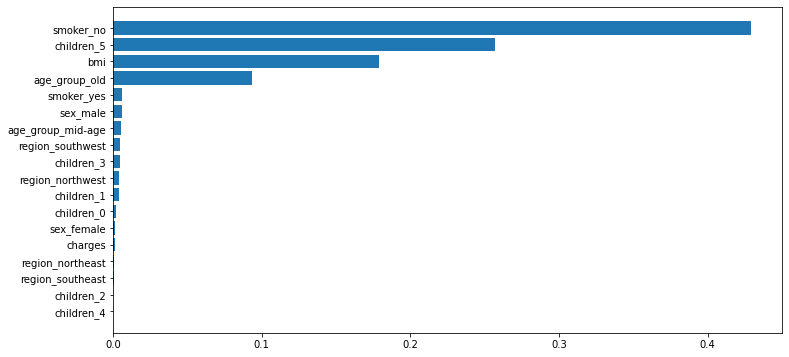

In [66]:
feature_importance = f_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(health_ins_df_processed.columns)[sorted_idx])
plt.show()

The model built using the sample dataset shows that the most important variables that predict the health insurance cost of a customer are:
* If the customer is not a smoker
* If the customer has children
* If the customer has a BMI
* If the customer is very old

## Save the model

In [67]:
f_model


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.015, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=250,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [68]:
# save the model to disk
filename = 'health_insurance_data_model.sav'
pickle.dump(f_model, open(filename, 'wb'))

## Predict on Test Dataset

In [69]:
# load the model from disk
filename = 'health_insurance_data_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result) #This is the estimated accuracy on the unseen dataset

0.9015343118101079
